In [1]:
%pwd

'/Users/ruixu/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Rui Xu-Research/Colon cancer mutiomics study 2022F-/Data analysis/4.ANN OCCPI analysis/OCCPI.Nstg'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import random
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Activation, Input, Dense
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from matplotlib import rcParams
from matplotlib.backends.backend_pdf import PdfPages
from tensorflow.keras.models import Model, Sequential

2025-01-07 02:43:25.838618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('/Users/ruixu/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Rui Xu-Research/Colon cancer mutiomics study 2022F-/Data analysis/4.ANN OCCPI analysis/OCCPI.Nstg/OCCPI.Nstg.csv', index_col=0)
df = df.replace([np.inf, -np.inf], np.nan)
cols_to_fillna = df.columns[2:]
df[cols_to_fillna] = df[cols_to_fillna].fillna(df[cols_to_fillna].mean())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 346 entries, A.338 to A.169
Columns: 241 entries, Nstg to Xanthosine dihydrate
dtypes: float64(240), int64(1)
memory usage: 654.2+ KB
None


In [4]:
X = df.iloc[:, 1:]  
y = df['Nstg']  
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=1/7, random_state=42, stratify=y_train)
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.fit_transform(X_val)
X_test_normalized = scaler.transform(X_test)
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)
print("y_train group counts:\n", pd.Series(y_train).value_counts())
print("y_val group counts:\n", pd.Series(y_val).value_counts())
print("y_test group counts:\n", pd.Series(y_test).value_counts())

y_train group counts:
 0    103
1     62
2     42
Name: Nstg, dtype: int64
y_val group counts:
 0    52
1    31
2    21
Name: Nstg, dtype: int64
y_test group counts:
 0    18
1    10
2     7
Name: Nstg, dtype: int64


In [5]:
def build_model(hidden_layers=5, layer_size=12, learning_rate=4.6e-3,
                activation='relu', regularization = 'l2', reg_strength = 3.8e-2, batch_size=128):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation=activation, input_shape=(X_train.shape[1],)))
    
    if regularization is not None:
        if regularization == 'l1':
            reg = keras.regularizers.l1(reg_strength)
        elif regularization == 'l2':
            reg = keras.regularizers.l2(reg_strength)
        else:
            raise ValueError("Invalid regularization type. Choose 'l1' or 'l2'.")
        model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
    else:
        model.add(keras.layers.Dense(layer_size, activation=activation))
    for _ in range(hidden_layers-1):
        if regularization is not None:
            model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
        else:
            model.add(keras.layers.Dense(layer_size, activation=activation))
    
    model.add(keras.layers.Dense(3))
    model.add(Activation('softmax'))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def plot_learning_curves(history, pdf_filename='learning_curves.pdf',ylim=(0, 2.5)):
    rcParams['pdf.fonttype'] = 42  
    rcParams['font.family'] = 'Arial'
    fig, ax = plt.subplots(figsize=(8, 5))
    pd.DataFrame(history.history).plot(ax=ax)
    ax.grid(False)
    ax.set_ylim(*ylim)
    max_epochs = len(history.history['loss'])
    ax.set_xticks(range(0, max_epochs + 1, 25))
    ax.tick_params(labelsize=20)  
    ax.legend(loc='upper right', fontsize=20)  
    with PdfPages(pdf_filename) as pdf:
        pdf.savefig(fig, bbox_inches='tight')

/var/folders/xm/v410f3rx60n6h8209h6jtpww0000gn/T/ipykernel_92873/190375854.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model = keras.wrappers.scikit_learn.KerasClassifier(build_model)
2025-01-07 02:43:32.782048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 5ms/step - loss: 2.4303 - accuracy: 0.5143
Test Accuracy: 0.5142857432365417
2/2 [==============================] - 0s 3ms/step
AUC Scores: [0.51633987 0.608      0.33673469]


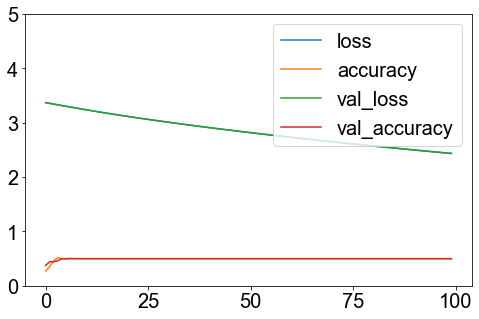

In [6]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
sklearn_model = keras.wrappers.scikit_learn.KerasClassifier(build_model)
history1 = sklearn_model.fit(X_train_normalized, y_train_one_hot,
                            epochs = 100,
                            validation_data=(X_val_normalized,y_val_one_hot), 
                            verbose=0)
        
plot_learning_curves(history1, pdf_filename='learning_curve_1.pdf',ylim=(0, 5))
test_accuracy = sklearn_model.score(X_test_normalized, y_test_one_hot)
print("Test Accuracy:", test_accuracy)
y_pred_prob = sklearn_model.predict_proba(X_test_normalized)
auc_scores = roc_auc_score(y_test_one_hot, y_pred_prob, average=None)
print("AUC Scores:", auc_scores)

In [7]:
def build_encoder(encoding_dim):
    # Define the encoder model
    input_dim = X_train_normalized.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    encoder = Model(input_layer, encoded)
    encoder.compile(optimizer='adam', loss='mse')
    return encoder
def build_model_after_encoder(hidden_layers=5, 
                              layer_size = 12,
                              learning_rate = 4.6e-3,
                              activation = 'relu',
                              regularization = 'l2',
                              reg_strength = 3.8e-2,
                              batch_size = 128):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation=activation))
    if regularization is not None:
        if regularization == 'l1':
            reg = keras.regularizers.l1(reg_strength)
        elif regularization == 'l2':
            reg = keras.regularizers.l2(reg_strength)
        else:
            raise ValueError("Invalid regularization type. Choose 'l1' or 'l2'.")
        model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
    else:
        model.add(keras.layers.Dense(layer_size, activation=activation))
    
    for _ in range(hidden_layers-1):
        if regularization is not None:
            model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
        else:
            model.add(keras.layers.Dense(layer_size, activation=activation))
    
    model.add(keras.layers.Dense(3))
    model.add(keras.layers.Activation('softmax'))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
best_test_accuracy = 0
best_encoding_dim = None
best_loss = float('inf')
best_history = None
best_model = None

for encoding_dim in range(2, 11):
    encoder_model = build_encoder(encoding_dim)
    X_train_encoded = encoder_model.predict(X_train_normalized)
    X_val_encoded = encoder_model.predict(X_val_normalized)
    X_test_encoded = encoder_model.predict(X_test_normalized)
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)
    sklearn_model2 = KerasClassifier(build_fn=build_model_after_encoder)
    history = sklearn_model2.fit(X_train_encoded, y_train_one_hot,
                            epochs=100,
                            validation_data=(X_val_encoded, y_val_one_hot),
                            verbose=0)

    test_accuracy = sklearn_model2.score(X_test_encoded, y_test_one_hot)
    print(f"Encoding Dim: {encoding_dim}, Test Accuracy: {test_accuracy}")
    
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_encoding_dim = encoding_dim
        best_history = history
        best_model = sklearn_model

2/2 [==============================] - 0s 3ms/step


/var/folders/xm/v410f3rx60n6h8209h6jtpww0000gn/T/ipykernel_92873/2773793840.py:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model2 = KerasClassifier(build_fn=build_model_after_encoder)


2/2 [==============================] - 0s 4ms/step - loss: 2.4239 - accuracy: 0.5143
Encoding Dim: 2, Test Accuracy: 0.5142857432365417
2/2 [==============================] - 0s 4ms/step - loss: 2.4208 - accuracy: 0.5143
Encoding Dim: 3, Test Accuracy: 0.5142857432365417
2/2 [==============================] - 0s 4ms/step - loss: 2.4220 - accuracy: 0.5143
Encoding Dim: 4, Test Accuracy: 0.5142857432365417
2/2 [==============================] - 0s 5ms/step - loss: 2.4216 - accuracy: 0.5143
Encoding Dim: 5, Test Accuracy: 0.5142857432365417
2/2 [==============================] - 0s 4ms/step - loss: 2.4208 - accuracy: 0.5143
Encoding Dim: 6, Test Accuracy: 0.5142857432365417
2/2 [==============================] - 0s 5ms/step - loss: 2.4230 - accuracy: 0.5143
Encoding Dim: 7, Test Accuracy: 0.5142857432365417
2/2 [==============================] - 0s 4ms/step - loss: 2.4245 - accuracy: 0.5143
Encoding Dim: 8, Test Accuracy: 0.5142857432365417
2/2 [==============================] - 0s 4ms/st

Best Encoding Dim: 2, Best Test Accuracy: 0.5142857432365417


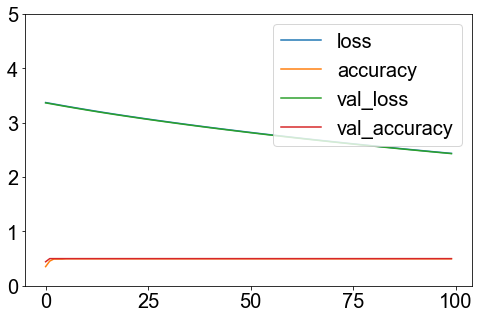

In [8]:
print(f"Best Encoding Dim: {best_encoding_dim}, Best Test Accuracy: {best_test_accuracy}")
history2 = best_history
plot_learning_curves(history2, pdf_filename='learning_curve_2.pdf',ylim=(0, 5))

In [9]:
df1 = pd.read_csv('/Users/ruixu/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Rui Xu-Research/Colon cancer mutiomics study 2022F-/Data analysis/4.ANN OCCPI analysis/OCCPI.Nstg/plsda_score.csv', index_col=0)

In [10]:
df1 = df1.replace([np.inf, -np.inf], np.nan)
cols_to_fillna = df1.columns[2:]
df1[cols_to_fillna] = df1[cols_to_fillna].fillna(df1[cols_to_fillna].mean())
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 346 entries, A.338 to A.169
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Nstg    346 non-null    int64  
 1   Comp 1  346 non-null    float64
 2   Comp 2  346 non-null    float64
 3   Comp 3  346 non-null    float64
 4   Comp 4  346 non-null    float64
 5   Comp 5  346 non-null    float64
 6   Comp 6  346 non-null    float64
 7   Comp 7  346 non-null    float64
 8   Comp 8  346 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 27.0+ KB
None


In [11]:
X1 = df1.iloc[:, 1:]  
y1 = df1['Nstg']  
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.3, random_state=42, stratify=y1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_train, y1_train, test_size=1/7, random_state=42, stratify=y1_train)
scaler = StandardScaler()
X1_train_normalized = scaler.fit_transform(X1_train)
X1_val_normalized = scaler.fit_transform(X1_val)
X1_test_normalized = scaler.transform(X1_test)
y1_train_one_hot = to_categorical(y1_train)
y1_val_one_hot = to_categorical(y1_val)
y1_test_one_hot = to_categorical(y1_test)
print("y_train group counts:\n", pd.Series(y1_train).value_counts())
print("y_val group counts:\n", pd.Series(y1_val).value_counts())
print("y_test group counts:\n", pd.Series(y1_test).value_counts())

y_train group counts:
 0    103
1     62
2     42
Name: Nstg, dtype: int64
y_val group counts:
 0    52
1    31
2    21
Name: Nstg, dtype: int64
y_test group counts:
 0    18
1    10
2     7
Name: Nstg, dtype: int64


/var/folders/xm/v410f3rx60n6h8209h6jtpww0000gn/T/ipykernel_92873/1883091012.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model3 = KerasClassifier(build_fn=build_model, input_shape=(X1_train_normalized.shape[1],),


Test Accuracy: 0.6285714507102966


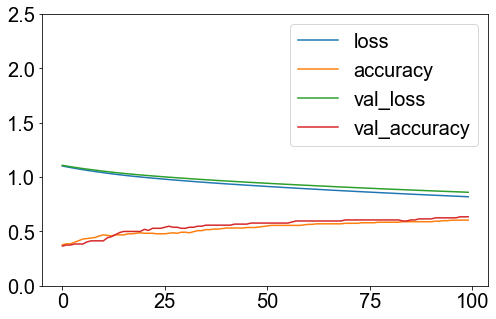

In [12]:
def build_model(input_shape, hidden_layers=1, layer_size=30, learning_rate=3e-3,
                activation='relu', regularization=None, reg_strength=1e-4, batch_size=32):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation=activation, input_shape=input_shape))
    
    if regularization is not None:
        if regularization == 'l1':
            reg = keras.regularizers.l1(reg_strength)
        elif regularization == 'l2':
            reg = keras.regularizers.l2(reg_strength)
        else:
            raise ValueError("Invalid regularization type. Choose 'l1' or 'l2'.")
        model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
    else:
        model.add(keras.layers.Dense(layer_size, activation=activation))
    
    for _ in range(hidden_layers-1):
   
        if regularization is not None:
            model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
        else:
            model.add(keras.layers.Dense(layer_size, activation=activation))
    
    model.add(keras.layers.Dense(3))
    model.add(Activation('softmax'))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
sklearn_model3 = KerasClassifier(build_fn=build_model, input_shape=(X1_train_normalized.shape[1],),
                                  epochs=100, batch_size=32, verbose=0)


history3 = sklearn_model3.fit(X1_train_normalized, y1_train_one_hot, validation_data=(X1_val_normalized, y1_val_one_hot))


test_accuracy = sklearn_model3.score(X1_test_normalized, y1_test_one_hot)

plot_learning_curves(history3, pdf_filename='learning_curve_3.pdf',ylim=(0, 2.5))
print("Test Accuracy:", test_accuracy)
